## Table of contents :
* [I - Build dataset](#first)
* [II - Preprocessing](#second)
    * [1 - Filter underpopulated classes](#second_1)
    * [2 - Crop images with object detection](#second_2)
    * [3 - Target EDA](#second_3) 
* [III - Build custom CNN architecture](#third)
    * [1 - Split training & testing sets (+ stratify & sample target)](#third_1)
    * [2 - Custom CNN](#third_2)
        * [2.1 - Training helpers](#third_2_1)
        * [2.2 - Find best Custom CNN architecture with bayesian optimization (Optuna)](#third_2_2)
        * [2.3 - Find best Custom CNN architecture with genetic algorithm (DEAP)](#third_2_3)
        * [2.4 - Train best custom CNN](#third_2_4)
* [IV - Transfert learning : pretrained architectures](#fourth)
    * [1 - Split training & testing sets (use all breeds)](#fourth_1)
    * [2 - NASNetMobile](#fourth_2)
    * [3 - NASNetLarge](#fourth_3)
    * [4 - Evaluation](#fourth_4)
* [V - Best model optimization](#fifth)
    * [1 - Pruning](#fifth_1)
    * [2 - Quantization](#fifth_2)
* [IV - Next steps](#sixth)

In [1]:
# Work environment configuration (Kaggle version)

!mkdir src Images
!cp -r ../input/src-zip/src/* ../working/src/
# Original images from Stanford dogs dataset
!cp -r ../input/stanford-dogs-dataset/Images/* ../working/Images/        
# Cropped images with object detection
# !cp -r ../input/stanford-dogs-dataset-cropped/Images/* ../working/Images/  
!pip install --upgrade pip
!pip install -r /kaggle/working/src/requirements.txt
!pip install -q tensorflow-model-optimization

# Work environment configuration (Google Colab version)

# !unzip src.zip
# !pip install -r src/requirements.txt
# !pip install -q tensorflow-model-optimization
# !rm -rf sample_data
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import gc
import re
import tarfile
import zipfile
import tempfile
import time
import cv2
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import tensorflow.keras.backend as K
import warnings
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, ImageDataGenerator
from tensorflow.keras.applications import Xception, DenseNet121, NASNetLarge, NASNetMobile, InceptionResNetV2
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.backend import clear_session
# Custom packages
from src.datacleaner import *
from src.analyzer.univariate import *
from src.preprocessor import get_features_importance, plot_cumulative_features_importance, fine_tuner
from src.evaluator import get_confusion_matrix, plot_confusion_matrix, classification_report, \
                          plot_training_curve, pickle_data
from src.hyperoptimizer.bayesian import optuna, BayesianOptimizer
from src.hyperoptimizer.genetic import GeneticAlgorithmOptimizer
from src.cv.image_preprocessor import *
from src.cv.object_detection import hub, ObjectDetector, crop_images_with_object_detection
from src.cv.cbam import attach_attention_module, cbam_block
%matplotlib inline
warnings.filterwarnings('ignore')

# I - Build dataset <a class="anchor" id="first"></a>

In [3]:
# Main global variables

# Google Colab global variables
# DRIVE_DATA_PATH = 'drive/MyDrive/OC-IML/P6/'
# IMG_TAR = 'images.tar'
# IMG_DATA_PATH = DRIVE_DATA_PATH + IMG_TAR
# IMG_DATA_PATH = DRIVE_DATA_PATH + "cropped_" + IMG_TAR # images data path (cropped version) 
IMG_PATH = 'Images/'
SEED = 42

# Enable random seeds
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Extract all images from .tar archive (Google Colab version)
# uncompress_tarfile(IMG_DATA_PATH)

# Get all breeds (raw labels)
raw_breeds = os.listdir(IMG_PATH)

# Clean raw labels and rename breed folders
for raw_breed in raw_breeds:
    breed_raw_folder = raw_breed # original breed folder label
    breed_folder = raw_breed[raw_breed.find('-') + 1:] # Extract breed label from string
    # Rename breed folder (comment this line if cropped images were imported)
    os.rename(os.path.join(IMG_PATH, breed_raw_folder), os.path.join(IMG_PATH, breed_folder))

# Build image file paths by breed dictionary
images_by_breed = {breed.split('/')[1]: [img for img in glob(breed+'/*')] for breed in glob('Images/*')}
# Filter corrupted image files
filter_corrupted_images(images_by_breed)
# Update image file paths
images_by_breed = {breed.split('/')[1]: [img for img in glob(breed+'/*')] for breed in glob('Images/*')}

Images/English_foxhound/n02089973_1492.jpg
Images/English_foxhound/n02089973_2331.jpg
Images/English_foxhound/n02089973_417.jpg
Images/English_foxhound/n02089973_3426.jpg
Images/Shetland_sheepdog/n02105855_5012.jpg
Images/Shetland_sheepdog/n02105855_2933.jpg
Images/otterhound/n02091635_1417.jpg
Images/otterhound/n02091635_1590.jpg
Images/otterhound/n02091635_3379.jpg
Images/otterhound/n02091635_3822.jpg
Deleted 10 images


In [4]:
# Build dataset 
train_data = {'img': [], 'breed': []}

for breed_idx, img_data in enumerate(images_by_breed.items()):
    breed, images = img_data
    for image in images:
        train_data['img'].append(image)
        train_data['breed'].append(breed)

df = pd.DataFrame(train_data)
print(df.shape)
print('Total breeds : {}'.format(len(df.breed.unique())))
print(df.head(2), '\n')

(20570, 2)
Total breeds : 120
                               img  breed
0  Images/boxer/n02108089_1357.jpg  boxer
1  Images/boxer/n02108089_4076.jpg  boxer 



# II - Preprocessing <a class="anchor" id="second"></a>

## 1 - Filter underpopulated classes <a class="anchor" id="second_1"></a>

In [5]:
# Keep current dataframe state (rows count)
original_rows_count = df.shape[0]
# Filter questions which have underpopulated classes
df = filter_underpopulated_classes(df, 'breed')
# Estimate data loss
get_data_loss(df, original_rows_count)

Dataframe rows inchanged (20570 -> 20570)


## 2 - Crop images with object detection <a class="anchor" id="second_2"></a>

In [6]:
# First we use MobileNetV2 which inference time is fast 
undetected_dogs = crop_images_with_object_detection(df.img.tolist(),
                                                    model='mobilenet_v2')

dogs detected : 20114/20570 (97.8%)
456 undetected dogs
Inference time:  1 h 24 min 50 s


In [7]:
# Then we use InceptionResnetV2 which is slow but more accurate to crop previous undetected dogs 
# (inference time takes at least 1s)
# crop 456 undetected dogs will take around 9 minutes which is affordable here
remaining_undetected_dogs = crop_images_with_object_detection(undetected_dogs,
                                                              model='inception_resnet_v2')
# Save cropped images
# make_tarfile(DRIVE_DATA_PATH+'cropped_'+IMG_TAR, IMG_PATH)   

dogs detected : 451/456 (98.9%)
5 undetected dogs
Inference time:  9 min 26 s


(20565, 2)

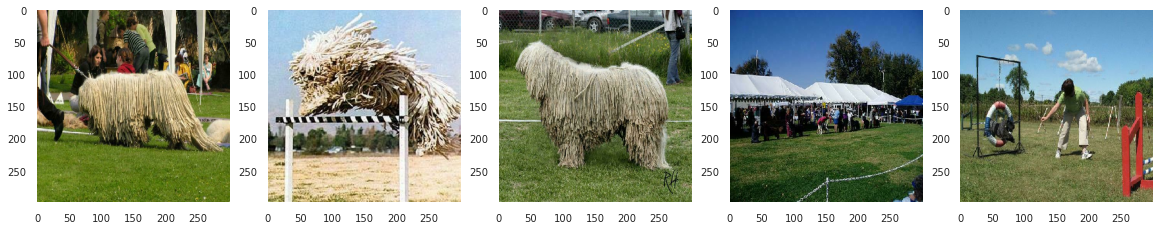

In [8]:
# Visualize outliers
fig, axs = plt.subplots(1, len(remaining_undetected_dogs), figsize=(20, 20))
for i, ax in enumerate(axs):
    resized_img = tf.image.resize(load_img(remaining_undetected_dogs[i]), [300, 300], method='nearest')
    ax.imshow(resized_img)
# Filter outliers (they can't be detected as dogs, animals or anything else)
df = df[~df.img.isin(remaining_undetected_dogs)]
df.shape

## 3 - Target EDA <a class="anchor" id="second_3"></a>


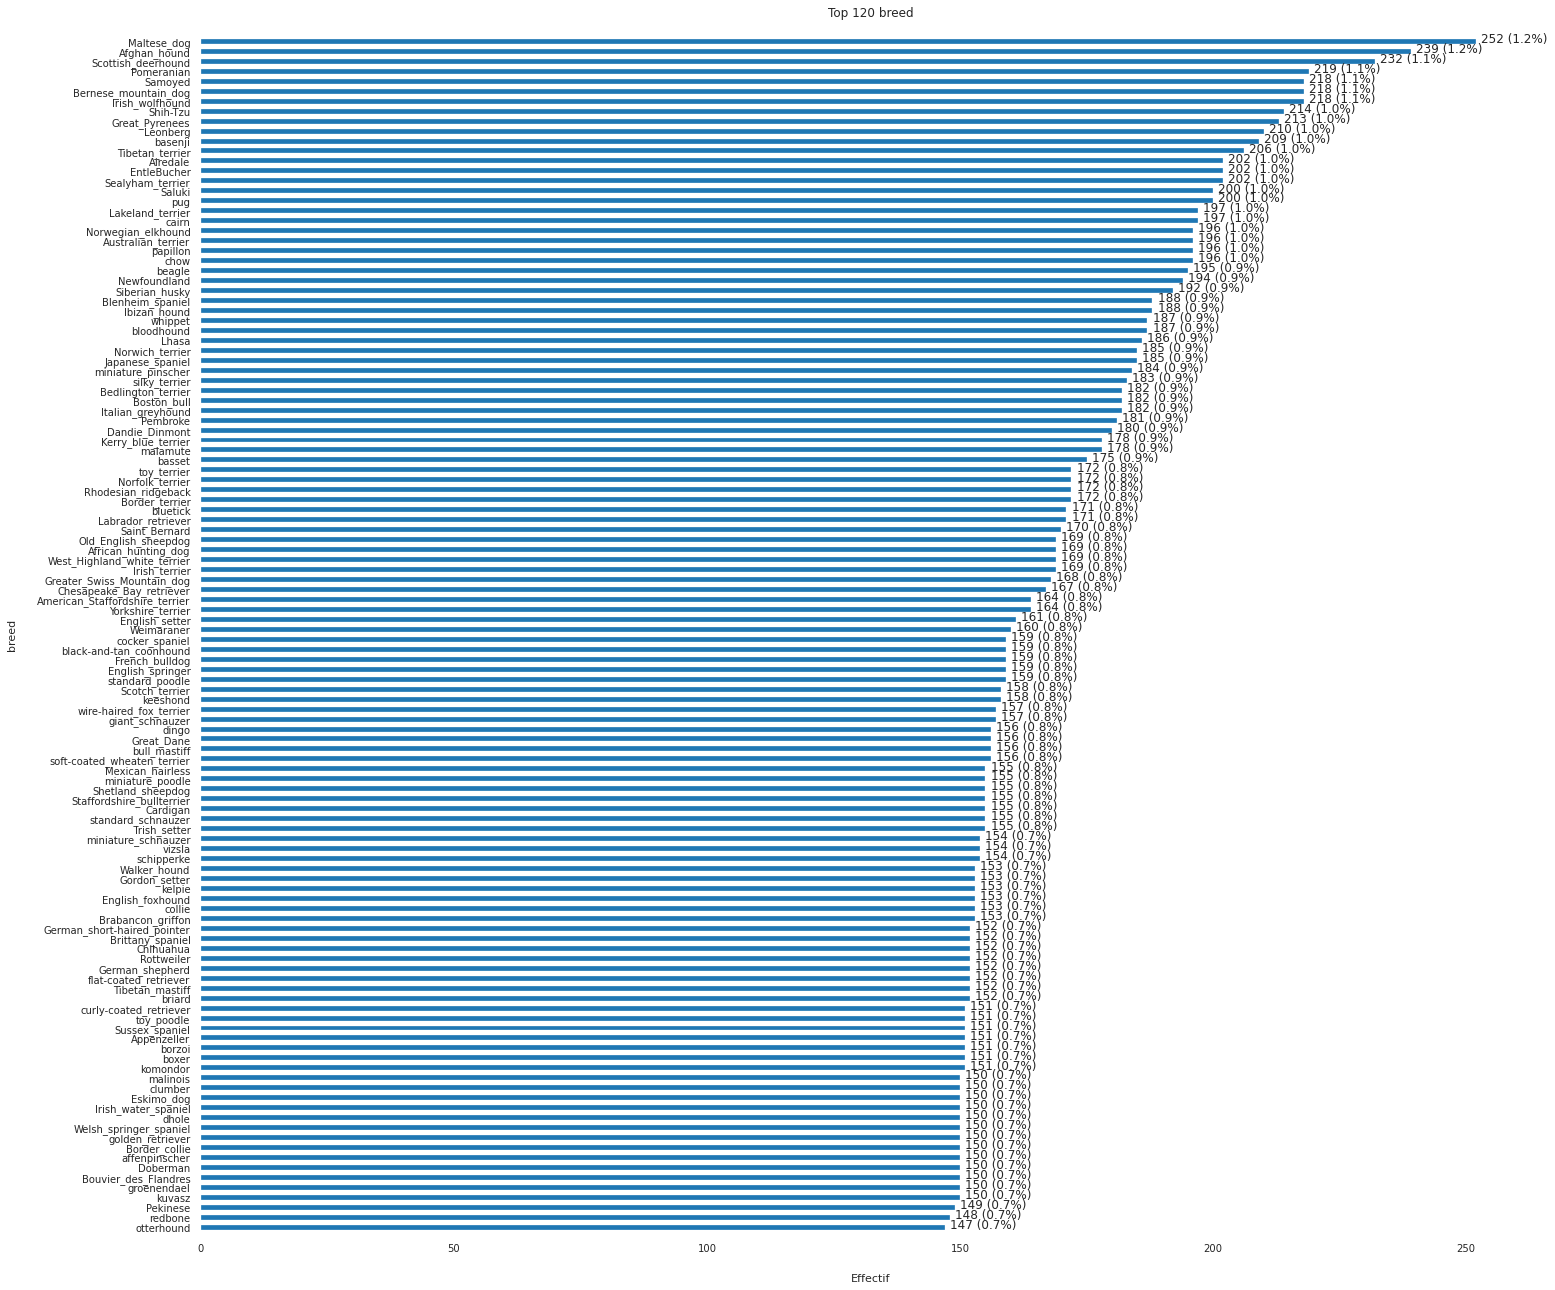

In [9]:
plot_n_top_values(df, 'breed', n=len(df.breed.unique().tolist()), plot_size=(24, 22), precision=1)

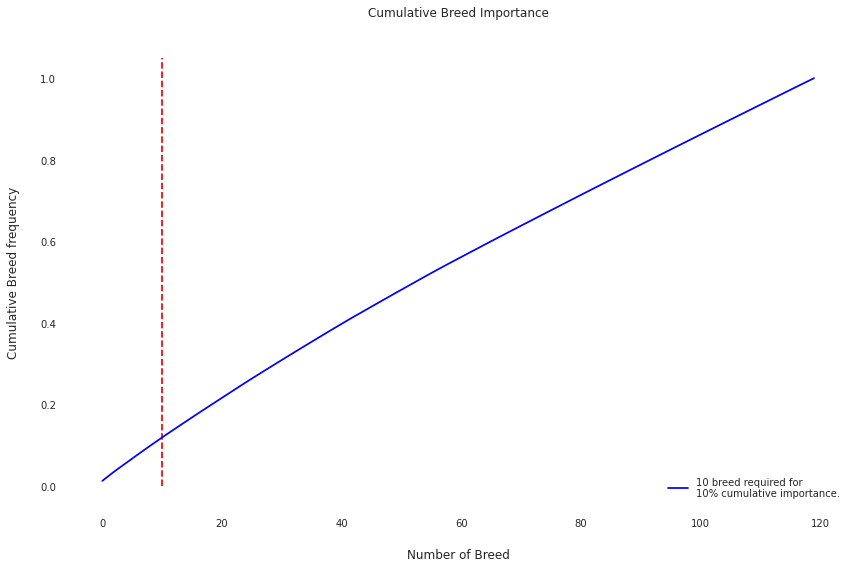

['Maltese_dog',
 'Afghan_hound',
 'Scottish_deerhound',
 'Pomeranian',
 'Samoyed',
 'Bernese_mountain_dog',
 'Irish_wolfhound',
 'Shih-Tzu',
 'Great_Pyrenees',
 'Leonberg']

In [10]:
breed_count = df.groupby('breed')['breed'].count().sort_values(ascending=False)

target_eda = breed_count.to_frame(name='count').reset_index()

target_freq = get_features_importance(target_eda['breed'], target_eda['count'])

n_selected_breeds = plot_cumulative_features_importance(target_freq,
                                                        threshold=0.1,
                                                        feature_type='breed',
                                                        return_threshold=True)

selected_breeds = target_freq['feature'][: n_selected_breeds].tolist()

selected_breeds

In [11]:
measures_table(target_freq.coefficient).T

,count,mean,std,min,25%,50%,75%,max
coefficient,120.0,171.375,23.297875,147.0,152.0,159.5,186.25,252.0


# III - Build custom CNN architecture <a class="anchor" id="third"></a>

## 1 - Split training & testing sets (+ stratify & sample target) <a class="anchor" id="third_1"></a>

In [12]:
# Sample target (select 10% most frequent breeds)
df_sample = df[df.breed.isin(selected_breeds)]
# Define target
target_sample = df_sample['breed']
# Split training & testing sets
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(df_sample['img'],
                                                                                target_sample,
                                                                                test_size=0.2,
                                                                                random_state=SEED,
                                                                                # Stratify K breeds (target)
                                                                                stratify=target_sample) 

print('\nTraining set : {} rows'.format(read_int_cleaner(X_train_sample.shape[0])))
print("Testing set : {} rows".format(read_int_cleaner(X_test_sample.shape[0])))

df_train_sample = pd.DataFrame({'img': X_train_sample, 'breed': y_train_sample})
df_test_sample = pd.DataFrame({'img': X_test_sample, 'breed': y_test_sample})

N_BREEDS = n_selected_breeds


Training set : 1 786 rows
Testing set : 447 rows


## 2 - Custom CNN <a class="anchor" id="third_2"></a>

#### 2.1 - Training helpers <a class="anchor" id="third_2_1"></a>

In [13]:
######################################################################################################
#                                          TRAINING                                                  #
######################################################################################################


# Custom garbage collector callback 
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()


class ImageClassifierTrainer:
    """
    Image classifier trainer which use Keras ImageDataGenerator to load and format images files  
    """
    def __init__(self, train_data, test_data, model, img_size, batch_size=32, seed=42, logdir='logs/'):
        self.train_data = train_data
        self.test_data = test_data
        self.model = model
        self.img_size = img_size
        self.batch_size = batch_size
        self.seed = seed
        self.logdir = logdir
        self.file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')
        self.train_generator = None
        self.test_generator = None
        self.history = None
        self.scores = None
        self.class_indices = None
        # Confusion matrix
        self.cm = None
    
    def build_image_data_generator(self, train_params, test_params, feature_col='img', target_col='breed'):
        # Rescale images from training set   
        train_image_data_generator = ImageDataGenerator(**train_params)
        # Rescale images from testing set
        test_image_data_generator = ImageDataGenerator(**test_params)
        # Commons image data generator flow parameters
        image_data_generator_params = {'x_col': feature_col,
                                       'y_col': target_col,
                                       'target_size': self.img_size,
                                       'color_mode': "rgb",
                                       'class_mode': "categorical",
                                       'batch_size': self.batch_size,
                                       'shuffle': True,
                                       'seed': self.seed} 
        # Train data batch generator
        self.train_generator = train_image_data_generator.flow_from_dataframe(self.train_data,
                                                                              **image_data_generator_params)
        # Test data batch generator
        self.test_generator = test_image_data_generator.flow_from_dataframe(self.test_data,
                                                                            **image_data_generator_params)
        # Get class indices sorted by indices (dictionary with class labels & indices)
        self.class_indices = dict(sorted(self.train_generator.class_indices.items(), key=lambda item: item[1]))
        return
    
    def data_augmentation(self, train_params, test_params):
        return self.build_image_data_generator(train_params, test_params)

    def compile_model(self,
                      model_optimizer=tf.keras.optimizers.Adam(),
                      model_loss='categorical_crossentropy',
                      model_metrics=['accuracy']):
        self.model.compile(optimizer=model_optimizer,
                           loss=model_loss,
                           metrics=model_metrics)
        return 
    
    def train(self,
              train_params,
              test_params,
              n_epochs,
              enable_data_augmentation=False,
              loaded_model=False,
              compile=True,
              model_callbacks=None,
              model_optimizer=tf.keras.optimizers.Adam(),
              model_loss='categorical_crossentropy',
              model_metrics=['accuracy'],
              train_verbose=1,
              **kwargs):
        
        # Update model
        if loaded_model:
            self.model = loaded_model
        # Build image data generators
        if enable_data_augmentation is False:
            self.build_image_data_generator(train_params, test_params)
        else:
            self.data_augmentation(train_params, test_params)
        # Garbage collector callback
        garbage_collector_callback = GarbageCollectorCallback()
        # TensorBoard callbacks
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=self.logdir, profile_batch=100000000)
        # per-epoch confusion matrix callback.
        confusion_matrix_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=self.log_confusion_matrix) 
        tensorboard_callbacks = [tensorboard_callback,
                                 confusion_matrix_callback,
                                 garbage_collector_callback]
        if model_callbacks is None:
            model_callbacks = tensorboard_callbacks
        else:
            model_callbacks.extend(tensorboard_callbacks)

        if compile:
            self.compile_model(model_optimizer, model_loss, model_metrics)
        # Train model
        history = self.model.fit(self.train_generator,
                                 epochs=n_epochs,
                                 steps_per_epoch=len(self.train_generator),
                                 callbacks=model_callbacks,
                                 validation_steps=len(self.test_generator),
                                 validation_data=self.test_generator,
                                 verbose=train_verbose,
                                 **kwargs)
        if self.history is None:
            self.history = history 
        else:
            self.history = {metric_label: self.history.history[metric_label] + history.history[metric_label] 
                            for metric_label in history.history.keys()}
        return
    
    def log_confusion_matrix(self, epoch, logs):
        # Use the model to predict the values from the validation dataset.
        test_pred_raw = self.model.predict(self.test_generator, len(self.test_generator))
        # test_pred = np.argmax(test_pred_raw)
        # Calculate the confusion matrix.
        class_labels = list(self.class_indices.keys())
        self.cm = get_confusion_matrix(self.test_generator.classes, test_pred_raw, class_labels)
        # cm = sklearn.metrics.confusion_matrix(self.test_generator.classes, test_pred)
        # Log the confusion matrix as an image summary.
        figure = plot_confusion_matrix(self.cm, class_labels)
        cm_image = plot_to_image(figure)
        # Log the confusion matrix as an image summary.
        with self.file_writer_cm.as_default():
            tf.summary.image("Confusion Matrix", cm_image, step=epoch)
        
    def evaluate(self, eval_verbose=1, return_dict=True, **kwargs):
        self.scores = self.model.evaluate(self.test_generator,
                                          verbose=eval_verbose,
                                          return_dict=return_dict,
                                          **kwargs)
        return self.scores
    
    def save_model(self, filename, **kwargs):
        self.model.save(f'{filename}.h5', **kwargs)
        return
    
    def load_model(self, filename, **kwargs):
        return tf.keras.models.load_model(filename, **kwargs)


######################################################################################################
#                                        FINE-TUNING                                                 #
######################################################################################################

# Fine tuning helper

def get_total_blocks(model, block_label_pattern='block', sep='_'):
    """
    :param model: a Tensorflow/Keras model
    :param block_label_pattern: block name string pattern 
                               (block name = "{string pattern}_{block number}")
    """
    blocks = set([int(layer.name.split(sep)[-1]) for layer in model.layers 
                  if block_label_pattern in layer.name])
    total_blocks = len(blocks)
    return total_blocks


def fine_tuner(model_layers, n_start=1, n=None, unfreeze=True):
    """
    Fine-tuning helper
    
    :param model_layers: model layers
    :param n_start: a layer number (layer index + 1) or name
    :param n: number of layers to consider (if None, all layers are considered by default)
    
    """
    if n is None:
        n = len(model_layers)
    if type(n_start) is str:
        n_start = list(map(lambda layer: layer.name, model_layers)).index(n_start)
    for layer in model_layers:
        for i in range(n_start, n + 1):
            if layer.name.startswith(f'block{i}'):
                layer.trainable = True if unfreeze is True else False
            else:
                layer.trainable = True if unfreeze is True else False
            # Freeze batch normalization layers
            if any(bn_pattern in str(layer.__class__) for bn_pattern in ['bn', 'BatchNormalization']):
                layer.trainable = False
    return


def get_gzipped_model_size(file):
    """
    
    Returns size of gzipped model, in bytes
    
    :param file: filename
    
    :return: model size in bytes
    
    """
    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)
    
    return os.path.getsize(zipped_file)


def get_conv_indexes_from_block(model, thr=0.5, conv_type='normal_conv'):
    """
    Get all convolutional layer indexes from the lowest N blocks (threshold based on quantile value)
    
    :param model: a Tensorflow/Keras model
    :param thr: quantile value
    :param conv_type: convolutional layer name type to target 
                     (will also select all sublayers starting from found pattern index)
    
    :return: a list of convolutional layer indexes
    """
    conv_idx_by_block = dict([(i, int(layer.name.split('_')[-1])) for i, layer in enumerate(model.layers) 
                              if conv_type in layer.name])
    total_blocks = max(list(conv_idx_by_block.values()))
    return [idx for idx, n_block in conv_idx_by_block.items() if n_block > round((1 - thr) * total_blocks)]

In [14]:
# Image data generators parameters

IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

BATCH_SIZE = 32

idg_train_test_params = {'train_params': {'rescale': 1./255},
                         'test_params': {'rescale': 1./255}}

# Data augmentation training & testing parameters
idg_da_train_test_params = {'train_params': {'rescale': 1./255,
                                             'rotation_range': 40,
                                             'width_shift_range': 0.2,
                                             'height_shift_range': 0.2,
                                             'shear_range': 0.2,
                                             'zoom_range': 0.2,
                                             'horizontal_flip': True},
                            'test_params': {'rescale': 1./255}}
                            
## Build temporary directory which stores model checkpoints 
checkpoint_filepath = 'tmp/checkpoint/'
os.makedirs(checkpoint_filepath, exist_ok=True) 
os.makedirs('logs/', exist_ok=True) 
# Model checkpoint complete filename
model_checkpoint = checkpoint_filepath+'model_with_no_DA.h5'
# Model callbacks
model_callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1),
                   ReduceLROnPlateau(monitor='val_accuracy', patience=1),
                   ModelCheckpoint(filepath=model_checkpoint,
                                   monitor='val_accuracy',
                                   mode='max',
                                   save_best_only=True),
                   EarlyStopping(monitor='val_accuracy', patience=3)]

#### 2.2 - Find best Custom CNN architecture with bayesian optimization (Optuna) <a class="anchor" id="third_2_2"></a>

In [15]:
# Optuna objective function

def objective(trial, min_units, max_units, eval_metric, epochs=1, verbose=False):
    # Clear clutter from previous Keras session graphs.
    clear_session()
    # Build CNN Architecture
    cnn = Sequential()
    # Define units range with power of two as step
    n_units_range = [pow(2, n) for n in range(int(np.log2(min_units)), int(np.log2(max_units))+1)]
    main_conv_layer_filter_size = trial.suggest_categorical('n_units', n_units_range)
    # Build first CNN layer (main layer)
    cnn.add(Conv2D(filters=main_conv_layer_filter_size,
                   kernel_size=(3, 3),
                   input_shape=IMG_SHAPE,
                   padding='same',
                   activation='relu'))
    # Pooling operation
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    # Add CNN hidden layers
    n_layers = trial.suggest_int('n_layers', 1, 4)
    for i in range(n_layers):
        num_hidden = trial.suggest_categorical(f'n_units_l{i+1}', n_units_range)
        cnn.add(Conv2D(num_hidden, (3, 3), padding='same', activation='relu', name=f'conv2d_l{i+1}'))
        cnn.add(MaxPooling2D(pool_size=(2, 2), name=f'max_pooling2d_l{i+1}'))
    # Flatten CNNs output
    cnn.add(Flatten())
    # Search optimal dropout rate
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)
    dropout_cond = trial.suggest_categorical('add_dropout', ['yes', 'no']) 
    if dropout_cond == 'yes':
        cnn.add(Dropout(dropout_rate))
    # Search optimal dense layer units
    # dense_n_units_range = [pow(2, n) for n in range(int(np.log2(min_units)), int(np.log2(max_units))+1)]
    # dense_num_units = trial.suggest_categorical('dense_n_units', dense_n_units_range)
    cnn.add(Dense(256, activation='relu', name='dense_l'))
    # Target dense layer 
    cnn.add(Dense(N_BREEDS, activation='softmax', name='target_dense_2'))  
    # We compile our model with a sampled learning rate.
    learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    # Find best optimizer
    # optimizer_type = trial.suggest_categorical('optimizer', ['RMSprop', 'Adam', 'SGD'])
    # if optimizer_type == 'RMSprop':
    #    optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate) 
    # elif optimizer_type == 'Adam':
    #    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    # elif optimizer_type == 'SGD':
    #    optimizer = tf.keras.optimizers.SGD(lr=learning_rate)
    if verbose:
        print('\n')
        cnn.summary()
        print('\n')
    # Add Optuna Keras pruner callback
    optuna_keras_callbacks = [optuna.integration.KerasPruningCallback(trial, "val_accuracy")]
    # Build model trainer
    img_cls_trainer = ImageClassifierTrainer(df_train_sample,
                                             df_test_sample,
                                             cnn,
                                             img_size=IMG_SIZE,
                                             batch_size=BATCH_SIZE,
                                             seed=SEED)
    # train model (compile & fit)
    img_cls_trainer.train(n_epochs=epochs,
                          enable_data_augmentation=False,
                          loaded_model=False,
                          compile=True,
                          model_callbacks=model_callbacks+optuna_keras_callbacks,
                          model_optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                          train_verbose=False,
                          **idg_train_test_params)
    # Evaluate model
    img_cls_trainer.evaluate(eval_verbose=False, return_dict=True)
    # Return score
    return img_cls_trainer.scores[eval_metric]  

 
# Use Bayesian optimization in order to find optimal CNN architecture
bo = BayesianOptimizer(objective_function=lambda t: objective(t,
                                                              min_units=16,
                                                              max_units=128,
                                                              eval_metric='accuracy',
                                                              epochs=2),
                       optimization_type='maximize')    
# Run Bayesian optimizer
# this is just an example (the scope of research was 1 000 trials which took few hours to compute)
study = bo.build_study(trials=100, n_cores=1, verbose=1) 

[I 2021-02-23 13:30:37,773] A new study created in memory with name: no-name-dbaa9ac5-a481-433f-b298-84ebaadbfbbd


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:30:54,517] Trial 0 finished with value: 0.45190155506134033 and parameters: {'n_units': 16, 'n_layers': 3, 'n_units_l1': 16, 'n_units_l2': 64, 'n_units_l3': 128, 'dropout_rate': 0.1398942906260463, 'add_dropout': 'no', 'lr': 0.00044665910520342715}. Best is trial 0 with value: 0.45190155506134033.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:31:12,653] Trial 1 finished with value: 0.4093959629535675 and parameters: {'n_units': 128, 'n_layers': 3, 'n_units_l1': 64, 'n_units_l2': 128, 'n_units_l3': 16, 'dropout_rate': 0.5009441987490229, 'add_dropout': 'no', 'lr': 0.0004622695251047916}. Best is trial 0 with value: 0.45190155506134033.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:31:30,308] Trial 2 finished with value: 0.3221476376056671 and parameters: {'n_units': 128, 'n_layers': 3, 'n_units_l1': 32, 'n_units_l2': 16, 'n_units_l3': 64, 'dropout_rate': 0.5185884911268798, 'add_dropout': 'no', 'lr': 0.0018888545806519535}. Best is trial 0 with value: 0.45190155506134033.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:31:46,820] Trial 3 finished with value: 0.11185682564973831 and parameters: {'n_units': 16, 'n_layers': 2, 'n_units_l1': 128, 'n_units_l2': 32, 'dropout_rate': 0.7921939757129949, 'add_dropout': 'no', 'lr': 0.005977870858964022}. Best is trial 0 with value: 0.45190155506134033.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:32:03,343] Trial 4 finished with value: 0.15659955143928528 and parameters: {'n_units': 16, 'n_layers': 4, 'n_units_l1': 128, 'n_units_l2': 32, 'n_units_l3': 128, 'n_units_l4': 16, 'dropout_rate': 0.5622099911786801, 'add_dropout': 'yes', 'lr': 9.107752315098756e-05}. Best is trial 0 with value: 0.45190155506134033.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:32:09,630] Trial 5 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:32:27,285] Trial 6 finished with value: 0.3445190191268921 and parameters: {'n_units': 128, 'n_layers': 2, 'n_units_l1': 64, 'n_units_l2': 64, 'dropout_rate': 0.3837184486658559, 'add_dropout': 'no', 'lr': 0.001560490778045916}. Best is trial 0 with value: 0.45190155506134033.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:32:33,244] Trial 7 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:32:40,422] Trial 8 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:32:47,162] Trial 9 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:32:53,062] Trial 10 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:33:09,827] Trial 11 finished with value: 0.3378075957298279 and parameters: {'n_units': 64, 'n_layers': 3, 'n_units_l1': 16, 'n_units_l2': 128, 'n_units_l3': 16, 'dropout_rate': 0.6329299569572165, 'add_dropout': 'no', 'lr': 0.00016392221061788334}. Best is trial 0 with value: 0.45190155506134033.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:33:16,122] Trial 12 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:33:22,973] Trial 13 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:33:39,242] Trial 14 finished with value: 0.47203579545021057 and parameters: {'n_units': 16, 'n_layers': 3, 'n_units_l1': 16, 'n_units_l2': 16, 'n_units_l3': 128, 'dropout_rate': 0.4234592756052966, 'add_dropout': 'no', 'lr': 0.00046086661567039416}. Best is trial 14 with value: 0.47203579545021057.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:33:55,077] Trial 15 finished with value: 0.4205816686153412 and parameters: {'n_units': 16, 'n_layers': 2, 'n_units_l1': 16, 'n_units_l2': 16, 'dropout_rate': 0.20672742574072128, 'add_dropout': 'no', 'lr': 0.00061847325072737}. Best is trial 14 with value: 0.47203579545021057.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:34:01,497] Trial 16 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:34:07,668] Trial 17 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:34:23,087] Trial 18 finished with value: 0.3758389353752136 and parameters: {'n_units': 16, 'n_layers': 2, 'n_units_l1': 16, 'n_units_l2': 16, 'dropout_rate': 0.29062871458156025, 'add_dropout': 'no', 'lr': 0.0003592691684840881}. Best is trial 14 with value: 0.47203579545021057.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:34:29,464] Trial 19 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:34:36,376] Trial 20 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:34:52,046] Trial 21 finished with value: 0.4205816686153412 and parameters: {'n_units': 16, 'n_layers': 2, 'n_units_l1': 16, 'n_units_l2': 16, 'dropout_rate': 0.22575211754904012, 'add_dropout': 'no', 'lr': 0.0003875991853335837}. Best is trial 14 with value: 0.47203579545021057.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:35:05,156] Trial 22 pruned. Trial was pruned at epoch 1.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:35:18,119] Trial 23 pruned. Trial was pruned at epoch 1.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:35:24,255] Trial 24 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:35:30,001] Trial 25 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:35:36,468] Trial 26 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:35:52,055] Trial 27 finished with value: 0.45190155506134033 and parameters: {'n_units': 16, 'n_layers': 2, 'n_units_l1': 16, 'n_units_l2': 16, 'dropout_rate': 0.4405564817411846, 'add_dropout': 'yes', 'lr': 0.00033561688994415397}. Best is trial 14 with value: 0.47203579545021057.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:35:58,215] Trial 28 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:36:14,516] Trial 29 finished with value: 0.42953020334243774 and parameters: {'n_units': 16, 'n_layers': 3, 'n_units_l1': 16, 'n_units_l2': 64, 'n_units_l3': 128, 'dropout_rate': 0.4786794123736128, 'add_dropout': 'yes', 'lr': 0.00045634458962567226}. Best is trial 14 with value: 0.47203579545021057.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:36:21,366] Trial 30 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:36:37,296] Trial 31 finished with value: 0.49440714716911316 and parameters: {'n_units': 16, 'n_layers': 3, 'n_units_l1': 16, 'n_units_l2': 64, 'n_units_l3': 128, 'dropout_rate': 0.45682163041740886, 'add_dropout': 'yes', 'lr': 0.0004051968131881969}. Best is trial 31 with value: 0.49440714716911316.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:36:53,984] Trial 32 finished with value: 0.4161073863506317 and parameters: {'n_units': 16, 'n_layers': 3, 'n_units_l1': 16, 'n_units_l2': 64, 'n_units_l3': 128, 'dropout_rate': 0.48868956900804034, 'add_dropout': 'yes', 'lr': 0.00024076144576147795}. Best is trial 31 with value: 0.49440714716911316.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:37:00,004] Trial 33 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:37:05,917] Trial 34 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:37:12,291] Trial 35 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:37:18,375] Trial 36 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:37:24,276] Trial 37 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:37:30,544] Trial 38 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:37:36,429] Trial 39 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:37:42,252] Trial 40 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:37:55,429] Trial 41 pruned. Trial was pruned at epoch 1.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:38:01,432] Trial 42 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:38:07,417] Trial 43 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:38:13,320] Trial 44 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:38:20,187] Trial 45 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:38:33,115] Trial 46 pruned. Trial was pruned at epoch 1.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:38:38,816] Trial 47 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:38:44,956] Trial 48 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:38:51,253] Trial 49 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:38:57,323] Trial 50 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:39:09,752] Trial 51 pruned. Trial was pruned at epoch 1.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:39:22,573] Trial 52 pruned. Trial was pruned at epoch 1.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:39:35,034] Trial 53 pruned. Trial was pruned at epoch 1.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:39:40,793] Trial 54 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:39:46,577] Trial 55 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:39:52,580] Trial 56 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:39:59,069] Trial 57 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:40:04,717] Trial 58 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:40:20,609] Trial 59 finished with value: 0.45190155506134033 and parameters: {'n_units': 64, 'n_layers': 2, 'n_units_l1': 16, 'n_units_l2': 16, 'dropout_rate': 0.5043618759121761, 'add_dropout': 'no', 'lr': 0.00018852050183094924}. Best is trial 31 with value: 0.49440714716911316.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:40:26,800] Trial 60 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:40:32,842] Trial 61 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:40:38,610] Trial 62 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:40:44,704] Trial 63 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:40:50,609] Trial 64 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:40:56,654] Trial 65 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:41:09,484] Trial 66 pruned. Trial was pruned at epoch 1.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:41:15,477] Trial 67 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:41:21,241] Trial 68 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:41:27,392] Trial 69 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:41:33,779] Trial 70 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:41:46,474] Trial 71 pruned. Trial was pruned at epoch 1.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:42:02,434] Trial 72 finished with value: 0.47651007771492004 and parameters: {'n_units': 16, 'n_layers': 2, 'n_units_l1': 16, 'n_units_l2': 16, 'dropout_rate': 0.2193695306160094, 'add_dropout': 'no', 'lr': 0.0008408290637722755}. Best is trial 31 with value: 0.49440714716911316.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:42:08,098] Trial 73 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:42:20,868] Trial 74 pruned. Trial was pruned at epoch 1.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:42:26,445] Trial 75 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:42:32,266] Trial 76 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:42:48,099] Trial 77 finished with value: 0.42505592107772827 and parameters: {'n_units': 16, 'n_layers': 3, 'n_units_l1': 16, 'n_units_l2': 32, 'n_units_l3': 128, 'dropout_rate': 0.16894169727024144, 'add_dropout': 'yes', 'lr': 0.0006904030440735287}. Best is trial 31 with value: 0.49440714716911316.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:42:54,095] Trial 78 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:43:00,329] Trial 79 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:43:06,873] Trial 80 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:43:19,644] Trial 81 pruned. Trial was pruned at epoch 1.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:43:32,573] Trial 82 pruned. Trial was pruned at epoch 1.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:43:48,926] Trial 83 finished with value: 0.4608501195907593 and parameters: {'n_units': 16, 'n_layers': 3, 'n_units_l1': 16, 'n_units_l2': 32, 'n_units_l3': 32, 'dropout_rate': 0.21170285342733944, 'add_dropout': 'yes', 'lr': 0.0004848841279752939}. Best is trial 31 with value: 0.49440714716911316.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:43:54,608] Trial 84 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:44:00,572] Trial 85 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:44:06,206] Trial 86 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:44:12,701] Trial 87 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:44:25,202] Trial 88 pruned. Trial was pruned at epoch 1.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:44:40,759] Trial 89 finished with value: 0.4384787380695343 and parameters: {'n_units': 16, 'n_layers': 3, 'n_units_l1': 16, 'n_units_l2': 32, 'n_units_l3': 32, 'dropout_rate': 0.49669831073831994, 'add_dropout': 'yes', 'lr': 0.0004898915324744017}. Best is trial 31 with value: 0.49440714716911316.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:44:47,343] Trial 90 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:44:52,971] Trial 91 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:44:58,778] Trial 92 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:45:04,371] Trial 93 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:45:10,299] Trial 94 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:45:26,410] Trial 95 finished with value: 0.44742730259895325 and parameters: {'n_units': 16, 'n_layers': 3, 'n_units_l1': 16, 'n_units_l2': 32, 'n_units_l3': 128, 'dropout_rate': 0.6244242619687128, 'add_dropout': 'yes', 'lr': 0.000927626099006255}. Best is trial 31 with value: 0.49440714716911316.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:45:32,457] Trial 96 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:45:38,693] Trial 97 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:45:44,370] Trial 98 pruned. Trial was pruned at epoch 0.


Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


[I 2021-02-23 13:45:50,754] Trial 99 pruned. Trial was pruned at epoch 0.


Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  79  (79.0%)
  Number of complete trials:  21  (21.0%)
Best trial:
  Value:  0.49440714716911316
  Params: 
    n_units: 16
    n_layers: 3
    n_units_l1: 16
    n_units_l2: 64
    n_units_l3: 128
    dropout_rate: 0.45682163041740886
    add_dropout: yes
    lr: 0.0004051968131881969


In [16]:
bo.plot_param_importances(study) 

In [17]:
bo.plot_optimization_history(study) 

#### 2.3 - Find best Custom CNN architecture with genetic algorithm (DEAP) <a class="anchor" id="third_2_3"></a>

In [20]:
# Genetic algorithm hyperparameters space

hyperparameters_space = {'n_units_range_l1': [16, 128],
                         'add_layer': ['yes', 'no'],
                         'n_added_layers': [1, 3],
                         'n_units_range_l2': [16, 128],
                         'n_units_range_l3': [16, 128],
                         'n_units_range_l4': [16, 128],
                         'add_dropout': ['yes', 'no'],
                         'dropout_range': [0.2, 0.5],
                         'n_units_range_dense1': [32, 128]
                        }

# Genetic algorithm objective function

def genetic_algorithm_objective_function(hyperparameters,
                                         n_classes=N_BREEDS,
                                         epochs=2,
                                         data_augmentation=False,
                                         eval_metric='accuracy',
                                         verbose=False,
                                         summary=False):
    # Clear clutter from previous Keras session graphs.
    clear_session()
    # Build CNN Architecture
    cnn = Sequential()
    # Build first CNN layer (main layer)
    cnn.add(Conv2D(filters=hyperparameters[0],
                   kernel_size=(3, 3),
                   input_shape=IMG_SHAPE,
                   padding='same',
                   activation='relu'))
    # Pooling operation
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    # # Add CNN hidden layers
    if hyperparameters[1] == 'yes':
        for i in range(1, hyperparameters[2]+1):
            cnn.add(Conv2D(filters=hyperparameters[2+i],
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu',
                           name=f'conv2d_l{i+1}'))
            cnn.add(MaxPooling2D(pool_size=(2, 2),
                                 name=f'max_pooling2d_l{i+1}'))
    # Flatten CNNs output
    cnn.add(Flatten())
    # Search optimal dropout rate
    if hyperparameters[6] == 'yes':
        cnn.add(Dropout(hyperparameters[7]))
    cnn.add(Dense(hyperparameters[8], activation='relu', name='dense_l'))
    # Target dense layer 
    cnn.add(Dense(n_classes, activation='softmax', name='target_dense_2'))
    # TO DO add best learning rate search
    print('\n')
    if summary:
        cnn.summary()
    print('\n')
    # Build model trainer
    img_cls_trainer = ImageClassifierTrainer(df_train_sample,
                                             df_test_sample,
                                             cnn,
                                             img_size=IMG_SIZE,
                                             batch_size=BATCH_SIZE,
                                             seed=SEED)
    # train model (compile & fit)
    img_cls_trainer.train(n_epochs=epochs,
                          enable_data_augmentation=data_augmentation,
                          loaded_model=False,
                          compile=True,
                          model_callbacks=model_callbacks,
                          model_optimizer=tf.keras.optimizers.Adam(),
                          train_verbose=False,
                          **idg_train_test_params)
    # Evaluate model
    img_cls_trainer.evaluate(eval_verbose=False, return_dict=True)
    # Return score
    return img_cls_trainer.scores[eval_metric]

# Build hyperparameters search with genetic algorithm hyperparameters optimizer 
# N.B : this is an example (computation time is expensive without distributed system)
ga = GeneticAlgorithmOptimizer(hyperparameters_space,
                               genetic_algorithm_objective_function,
                               population_size=5,
                               crossover_probability=0.7,
                               mutation_probability=0.1, 
                               number_of_generations=3)
# Create individual & population 
ga.build_individual_and_population()
# Initialize best hyperparameters search
ga_results = ga.initiate_natural_selection(print_individual_genes=True)



------------------------------------------
-           Selected genes               -
------------------------------------------


n_units_range_l1 : 32
add_layer : no
n_added_layers : 2
n_units_range_l2 : 64
n_units_range_l3 : 64
n_units_range_l4 : 16
add_dropout : no
dropout_range : 0.4480091077896773
n_units_range_dense1 : 32




Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


------------------------------------------
-           Selected genes               -
------------------------------------------


n_units_range_l1 : 64
add_layer : yes
n_added_layers : 2
n_units_range_l2 : 16
n_units_range_l3 : 128
n_units_range_l4 : 32
add_dropout : yes
dropout_range : 0.4427108988914975
n_units_range_dense1 : 32




Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.


------------------------------------------
-           Selected genes      

In [21]:
# Display best hyperparameters
ga.best_params

{'n_units_range_l1': 16,
 'add_layer': 'yes',
 'n_added_layers': 2,
 'n_units_range_l2': 128,
 'n_units_range_l3': 128,
 'n_units_range_l4': 64,
 'add_dropout': 'no',
 'dropout_range': 0.29921701529251815,
 'n_units_range_dense1': 64}

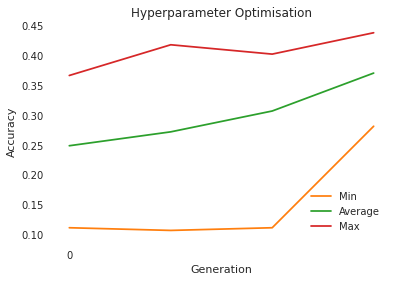

In [22]:
# Plot generation training curve
ga.plot_training_curve()

#### 2.4 - Train best custom CNN <a class="anchor" id="third_2_4"></a>

In [23]:
# Best trial:
#   Value:  0.4921700358390808
#   Params: 
#     n_units: 16
#     n_layers: 3
#     n_units_l1: 16
#     n_units_l2: 32
#     n_units_l3: 64
#     dropout_rate: 0.3789327081321794
#     add_dropout: no
#     lr: 0.0003760518309837886

# Build custom CNN
clear_session()
custom_cnn = Sequential()
custom_cnn.add(Conv2D(16, (3, 3), input_shape=IMG_SIZE+(3,), padding="same", activation='relu'))
custom_cnn.add(MaxPooling2D(pool_size=(2, 2)))
custom_cnn.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
custom_cnn.add(MaxPooling2D(pool_size=(2, 2)))
custom_cnn.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
custom_cnn.add(MaxPooling2D(pool_size=(2, 2)))
custom_cnn.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
custom_cnn.add(MaxPooling2D(pool_size=(2, 2)))
custom_cnn.add(Flatten())
custom_cnn.add(Dropout(0.4))
custom_cnn.add(Dense(256, activation='relu'))
custom_cnn.add(Dense(N_BREEDS, activation='softmax'))


initial_epochs = 5
data_augmentation_epochs = 10
total_epochs = initial_epochs + data_augmentation_epochs


#  Build model trainer
img_cls_trainer = ImageClassifierTrainer(df_train_sample,
                                         df_test_sample,
                                         custom_cnn,
                                         img_size=IMG_SIZE,
                                         batch_size=BATCH_SIZE,
                                         seed=SEED)
# Train model (compile & fit)
img_cls_trainer.train(n_epochs=initial_epochs,
                      enable_data_augmentation=False,
                      compile=True,
                      model_callbacks=model_callbacks,
                      model_optimizer=tf.keras.optimizers.Adam(0.00038),
                      train_verbose=True,
                      **idg_train_test_params)

# Get first step learning rate
first_step_learning_rate = K.eval(img_cls_trainer.model.optimizer.lr)
print(first_step_learning_rate)

# Add data augmentation
img_cls_trainer.train(n_epochs=total_epochs,
                      initial_epoch=img_cls_trainer.history.epoch[-1],
                      enable_data_augmentation=True,
                      loaded_model=img_cls_trainer.model,
                      model_callbacks=model_callbacks,
                      model_optimizer=tf.keras.optimizers.Adam(first_step_learning_rate),
                      train_verbose=True,
                      **idg_da_train_test_params)

# Evaluate model
img_cls_trainer.evaluate(eval_verbose=False, return_dict=True)

# Return score
img_cls_trainer.scores

Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.
Epoch 1/5
56/56 [==============================] - 44s 782ms/step - loss: 2.1090 - accuracy: 0.2156 - val_loss: 1.7609 - val_accuracy: 0.4004
Epoch 2/5
56/56 [==============================] - 42s 756ms/step - loss: 1.6017 - accuracy: 0.4143 - val_loss: 1.5256 - val_accuracy: 0.4541
Epoch 3/5
56/56 [==============================] - 44s 784ms/step - loss: 1.4415 - accuracy: 0.4720 - val_loss: 1.4997 - val_accuracy: 0.4609
Epoch 4/5
56/56 [==============================] - 45s 808ms/step - loss: 1.2363 - accuracy: 0.5622 - val_loss: 1.4135 - val_accuracy: 0.4899
Epoch 5/5
56/56 [==============================] - 47s 840ms/step - loss: 1.0995 - accuracy: 0.6120 - val_loss: 1.3965 - val_accuracy: 0.5235
0.00038
Found 1786 validated image filenames belonging to 10 classes.
Found 447 validated image filenames belonging to 10 classes.
Epoch 5/15
56/56 [==================

{'loss': 1.3968850374221802, 'accuracy': 0.5078299641609192}

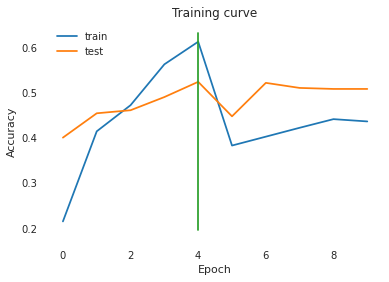

In [24]:
plot_training_curve(img_cls_trainer, fine_tuning=True, initial_epochs=initial_epochs)

# IV - Transfert learning : pretrained architectures <a class="anchor" id="fourth"></a>

## 1 - Split training & testing sets (use all breeds) <a class="anchor" id="fourth_1"></a>

In [25]:
# Split training & testing sets
X_train, X_test, y_train, y_test = train_test_split(df['img'],
                                                    df['breed'],
                                                    test_size=0.2,
                                                    random_state=SEED,
                                                    stratify=df['breed']) # Stratify K breeds (target)

print('\nTraining set : {} rows'.format(read_int_cleaner(X_train.shape[0])))
print("Testing set : {} rows".format(read_int_cleaner(X_test.shape[0])))

df_train = pd.DataFrame({'img': X_train, 'breed': y_train})
df_test = pd.DataFrame({'img': X_test, 'breed': y_test})

N_BREEDS = len(df['breed'].unique())

# Pre-trained selected models : NASNetMobile & NASNetLarge => https://keras.io/api/applications/nasnet/


Training set : 16 452 rows
Testing set : 4 113 rows


In [26]:
# Image preprocessing parameters

pretrained_model_input_preprocessor = tf.keras.applications.nasnet.preprocess_input

# Default image data generator training & testing parameters
idg_train_test_params = {'train_params': {# 'rescale': 1./255,
                                          'preprocessing_function': pretrained_model_input_preprocessor},
              
                         'test_params': {'preprocessing_function': pretrained_model_input_preprocessor}
                         }

# Data augmentation image data generator training & testing parameters
idg_da_train_test_params = {'train_params': {# 'rescale': 1./255,
                                             'preprocessing_function': pretrained_model_input_preprocessor,
                                             'rotation_range': 40,
                                             'width_shift_range': 0.2,
                                             'height_shift_range': 0.2,
                                             'shear_range': 0.2,
                                             'zoom_range': 0.2,
                                             'horizontal_flip': True},
              
                            'test_params': {'preprocessing_function': pretrained_model_input_preprocessor}
                            }

# Build temporary directory which stores model checkpoints
checkpoint_filepath = 'tmp/checkpoint/'
logdir_filepath = 'logs/'
os.makedirs(checkpoint_filepath, exist_ok=True) 
os.makedirs(logdir_filepath, exist_ok=True) 
# Model checkpoint complete filename
model_checkpoint = checkpoint_filepath+'model_with_no_DA.h5'
# Model callbacks
model_callbacks =  [ReduceLROnPlateau(monitor='val_loss',
                                      patience=1),
                    ReduceLROnPlateau(monitor='val_accuracy',
                                       patience=1),
                    ModelCheckpoint(filepath=model_checkpoint,
                                    monitor='val_accuracy',
                                    mode='max',
                                    save_best_only=True),
                    EarlyStopping(monitor='val_accuracy',
                                  patience=3)]

In [27]:
# Helper which create custom pretrained model from NASNetLarge or NASNetMobile architectures

def create_custom_pretrained_model(modele_type='large', n_blocks=None):
    if modele_type == 'large':
        pretrained_model = NASNetLarge(weights='imagenet', include_top=True)
        n_cls_layers = 4
    elif modele_type == 'mobile':
        pretrained_model = NASNetMobile(weights='imagenet', include_top=True)
        n_cls_layers = 3
    # Block output indexes
    block_indexes = [i for i, layer in enumerate(pretrained_model.layers) if 'normal_concat' in layer.name]
    if n_blocks:
        # Block output index
        n_block_idx = block_indexes[n_blocks-1]
        # Activation output (previous + selected blocks)
        n_block_output = pretrained_model.layers[n_block_idx+2].output 
        #
        # Last pooling layer
        x = tf.keras.layers.GlobalAveragePooling2D()(n_block_output)
    else:
        # Get last layer before target Dense layer (which is a GlobalAveragePooling2D layer)
        x = pretrained_model.layers[-2].output
    # Define the new layer/tensor for the new model
    x = tf.keras.layers.Dense(2**8, activation='relu')(x)
    if modele_type == 'large':
        x = tf.keras.layers.Dropout(0.7)(x)
    target_dense_output = tf.keras.layers.Dense(N_BREEDS, activation='softmax')(x)
    custom_pretrained_model = Model(pretrained_model.input,
                                    target_dense_output,
                                    name='fine_tuned_NASNet{}'.format(modele_type.upper()))
    # custom_pretrained_model.summary()
    # freezing all the layers of pretrained model by making them non trainable
    for layer in custom_pretrained_model.layers[:-n_cls_layers]:
        layer.trainable = False
    return custom_pretrained_model

## 2 - NASNetMobile <a class="anchor" id="fourth_2"></a>

In [28]:
clear_session()

# Create pretrained NasNetMobile model
nasnetmobile_custom_pretrained_model = create_custom_pretrained_model(modele_type='mobile')

# NasNetMobile block count
nasnetmobile_total_blocks = get_total_blocks(nasnetmobile_custom_pretrained_model,
                                             block_label_pattern='adjust_bn')

print('Total blocks : {}'.format(nasnetmobile_total_blocks))

# NasNetMobile image size
nasnetmobile_img_size = (224, 224)
    
initial_epochs = 5
                              
# Instantiate image classifier trainer
img_cls_trainer = ImageClassifierTrainer(df_train,
                                         df_test,
                                         nasnetmobile_custom_pretrained_model,
                                         img_size=nasnetmobile_img_size,
                                         batch_size=32,
                                         seed=SEED,
                                         logdir=logdir_filepath)

# Pretrain model based on n initial epochs
img_cls_trainer.train(n_epochs=initial_epochs,
                      enable_data_augmentation=True,
                      loaded_model=False,
                      model_callbacks=model_callbacks,
                      model_optimizer=tf.keras.optimizers.Adam(1e-4),
                      train_verbose=True,
                      **idg_da_train_test_params)

# Load best model checkpoint
loaded_model_checkpoint = load_model(model_checkpoint)

# Get first step learning rate
first_step_learning_rate = K.eval(loaded_model_checkpoint.optimizer.lr)
print(first_step_learning_rate)

# Start fine tuning
fine_tuner(model_layers=nasnetmobile_custom_pretrained_model.layers[:-3],
           n=len(nasnetmobile_custom_pretrained_model.layers[:-3]),
           n_start='separable_conv_2_normal_left1_2')

fine_tune_epochs = 4
total_epochs =  initial_epochs + fine_tune_epochs

# Train loaded model with data augmentation
img_cls_trainer.train(n_epochs=total_epochs,
                      initial_epoch=img_cls_trainer.history.epoch[-1],
                      enable_data_augmentation=True,
                      loaded_model=loaded_model_checkpoint,
                      model_callbacks=model_callbacks,
                      model_optimizer=tf.keras.optimizers.Adam(1e-5),
                      train_verbose=True,
                      **idg_da_train_test_params)

evaluated_custom_pretrained_model_baseline = img_cls_trainer.evaluate()
evaluated_custom_pretrained_model_baseline

24231936/24227760 [==============================] - 1s 0us/step
Total blocks : 13
Found 16452 validated image filenames belonging to 120 classes.
Found 4113 validated image filenames belonging to 120 classes.
Epoch 1/5
515/515 [==============================] - 274s 531ms/step - loss: 2.7200 - accuracy: 0.5041 - val_loss: 0.8648 - val_accuracy: 0.8364
Epoch 2/5
515/515 [==============================] - 265s 514ms/step - loss: 1.0107 - accuracy: 0.7459 - val_loss: 0.5723 - val_accuracy: 0.8471
Epoch 3/5
515/515 [==============================] - 265s 514ms/step - loss: 0.8657 - accuracy: 0.7569 - val_loss: 0.5185 - val_accuracy: 0.8544
Epoch 4/5
515/515 [==============================] - 268s 520ms/step - loss: 0.8047 - accuracy: 0.7696 - val_loss: 0.4986 - val_accuracy: 0.8546
Epoch 5/5
515/515 [==============================] - 267s 518ms/step - loss: 0.7957 - accuracy: 0.7686 - val_loss: 0.4999 - val_accuracy: 0.8500
1e-04
Found 16452 validated image filenames belonging to 120 clas

{'loss': 0.4915008246898651, 'accuracy': 0.8555798530578613}

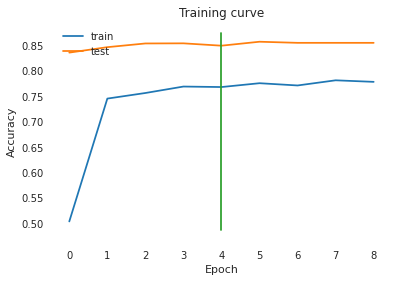

In [29]:
plot_training_curve(img_cls_trainer, fine_tuning=True, initial_epochs=initial_epochs)

 ## 3 - NASNetLarge <a class="anchor" id="fourth_3"></a>

In [30]:
clear_session()

# Create pretrained NasNetLarge model
nasnetlarge_custom_pretrained_model = create_custom_pretrained_model(n_blocks=None)

# NasNetLarge block count
nasnetlarge_total_blocks = get_total_blocks(nasnetlarge_custom_pretrained_model, 
                                            block_label_pattern='adjust_bn')

print('Total blocks : {}'.format(nasnetlarge_total_blocks))

# NasNetLarge image size
nasnetlarge_img_size = (331, 331)

initial_epochs = 5
                                  
# Instantiate image classifier trainer
img_cls_trainer = ImageClassifierTrainer(df_train,
                                         df_test,
                                         nasnetlarge_custom_pretrained_model,
                                         img_size=nasnetlarge_img_size,
                                         batch_size=32,   
                                         seed=SEED,
                                         logdir=logdir_filepath)

# Train model
img_cls_trainer.train(n_epochs=initial_epochs,
                      enable_data_augmentation=False,
                      loaded_model=False,
                      model_callbacks=model_callbacks,
                      model_optimizer=tf.keras.optimizers.Adam(1e-4),
                      train_verbose=True, 
                      **idg_train_test_params)  
# Evaluate model
evaluated_custom_pretrained_model_baseline = img_cls_trainer.evaluate()
evaluated_custom_pretrained_model_baseline

359751680/359748576 [==============================] - 9s 0us/step
Total blocks : 19
Found 16452 validated image filenames belonging to 120 classes.
Found 4113 validated image filenames belonging to 120 classes.
Epoch 1/5
515/515 [==============================] - 600s 1s/step - loss: 2.3768 - accuracy: 0.6374 - val_loss: 0.4817 - val_accuracy: 0.9370
Epoch 2/5
515/515 [==============================] - 582s 1s/step - loss: 0.5879 - accuracy: 0.9088 - val_loss: 0.2546 - val_accuracy: 0.9390
Epoch 3/5
515/515 [==============================] - 585s 1s/step - loss: 0.4000 - accuracy: 0.9223 - val_loss: 0.2326 - val_accuracy: 0.9397
Epoch 4/5
515/515 [==============================] - 591s 1s/step - loss: 0.3398 - accuracy: 0.9296 - val_loss: 0.2294 - val_accuracy: 0.9392
Epoch 5/5
129/129 [==============================] - 72s 557ms/step - loss: 0.2271 - accuracy: 0.9385


{'loss': 0.2270999252796173, 'accuracy': 0.938487708568573}

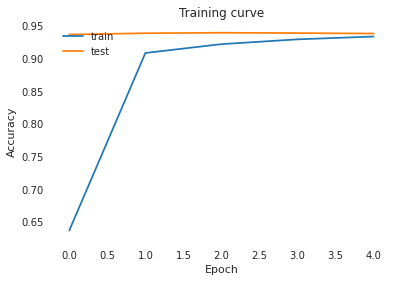

In [31]:
plot_training_curve(img_cls_trainer.history, fine_tuning=False, initial_epochs=initial_epochs)

In [36]:
# img_cls_trainer.model.save('dog_breeds_detector.h5')
img_cls_trainer.model.save_weights("dog_breeds_detector_weights.h5")

In [34]:
# Load weights from best model (trained in another session)

custom_pretrained_model = create_custom_pretrained_model()
custom_pretrained_model.load_weights('../input/best-model-weights/dog_breeds_detector_weights.h5')

img_cls_trainer = ImageClassifierTrainer(df_train,
                                         df_test,
                                         custom_pretrained_model,
                                         img_size=nasnetlarge_img_size,
                                         batch_size=32,
                                         seed=SEED,
                                         logdir=logdir_filepath)

img_cls_trainer.build_image_data_generator(**idg_train_test_params)

img_cls_trainer.model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                              loss='categorical_crossentropy',
                              metrics='accuracy')

evaluated_custom_pretrained_model_baseline = img_cls_trainer.evaluate()
evaluated_custom_pretrained_model_baseline

Found 16452 validated image filenames belonging to 120 classes.
Found 4113 validated image filenames belonging to 120 classes.
129/129 [==============================] - 72s 559ms/step - loss: 0.1902 - accuracy: 0.9460


{'loss': 0.19022975862026215, 'accuracy': 0.9460247755050659}

## 4 - Evaluation <a class="anchor" id="fourth_4"></a>

#### 4.1 - TensorBoard 

In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard
%tensorboard --logdir logs/

#### 4.2 - Grad-CAM class activation visualization 

In [ ]:
# Helper which display Grad-CAM from a specific image file path
def nasnetlarge_gradcam(img_path):
    img_array = pretrained_model_input_preprocessor(get_img_array(img_path, size=nasnetlarge_img_size))
    # Visualize Grad CAM
    return grad_cam(img_path, img_array, img_cls_trainer.model,
                    nasnetlarge_custom_pretrained_model.layers[-5].name)

nasnetlarge_gradcam(df.img.iloc[1000]).resize(nasnetlarge_img_size)

# V - Best model optimization <a class="anchor" id="fifth"></a>

## 1 - Pruning <a class="anchor" id="fifth_1"></a>

In [49]:
clear_session()

# Define model for pruning.
custom_pretrained_model = create_custom_pretrained_model()
# Load weights from best model
custom_pretrained_model.load_weights('dog_breeds_detector_weights.h5')

# Image preprocessing parameters
BATCH_SIZE = 32
num_images = len(img_cls_trainer.train_generator) * BATCH_SIZE
end_step = np.ceil(num_images / BATCH_SIZE).astype(np.int32) * 2

# Get lowest Conv2D layer index from the lowest n blocks (threshold based on quantile value)

normal_conv2d_min_idx = min(set(get_conv_indexes_from_block(model=custom_pretrained_model,
                                                            # 100 % means getting all layers from block n
                                                            # (tested quantiles : D1, Q1, Median)
                                                            thr=1.0,
                                                            # old value -> normal_conv_1_17
                                                            conv_type='normal_conv'))) 

                                                            
# Define pruning parameters
pruning_params = {'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.25,
                                                                           final_sparsity=0.95,
                                                                           begin_step=0,
                                                                           end_step=end_step)}

pruned_layers_types = (tf.keras.layers.Conv2D, tf.keras.layers.Dense)

# Helper function uses "prune_low_magnitude" to make only the Conv2D layers train with pruning.
def apply_pruning_to_conv(layer):
    # Prune upper layers starting from specific layer index
    layer_idx_cond = custom_pretrained_model.layers.index(layer) > normal_conv2d_min_idx
    if isinstance(layer, pruned_layers_types) and layer_idx_cond:
        return tfmot.sparsity.keras.prune_low_magnitude(layer)
    return layer

# Use "tf.keras.models.clone_model" to apply "apply_pruning_to_conv" to the layers of the model.
model_for_pruning = tf.keras.models.clone_model(custom_pretrained_model,
                                                clone_function=apply_pruning_to_conv)

# Pruning callbacks
pruning_callbacks = [tfmot.sparsity.keras.UpdatePruningStep(),
                     tfmot.sparsity.keras.PruningSummaries(log_dir=logdir_filepath)]

pruning_trainer = ImageClassifierTrainer(df_train,
                                         df_test,
                                         model_for_pruning,
                                         img_size=nasnetlarge_img_size,
                                         batch_size=BATCH_SIZE,
                                         seed=SEED,
                                         logdir=logdir_filepath)
# Prune model
pruning_trainer.train(n_epochs=5,
                      enable_data_augmentation=False,
                      model_callbacks=pruning_callbacks,
                      model_optimizer=tf.keras.optimizers.Adam(1e-5),
                      train_verbose=True,
                      **idg_train_test_params)

# Evaluate pruned model
evaluated_pruned_model = pruning_trainer.evaluate()

Found 16452 validated image filenames belonging to 120 classes.
Found 4113 validated image filenames belonging to 120 classes.
Epoch 1/5
515/515 [==============================] - 508s 987ms/step - loss: 0.4422 - accuracy: 0.9091 - val_loss: 0.2170 - val_accuracy: 0.9409
Epoch 2/5
515/515 [==============================] - 492s 955ms/step - loss: 0.4184 - accuracy: 0.9133 - val_loss: 0.2121 - val_accuracy: 0.9421
Epoch 3/5
515/515 [==============================] - 492s 956ms/step - loss: 0.4087 - accuracy: 0.9118 - val_loss: 0.2093 - val_accuracy: 0.9426
Epoch 4/5
515/515 [==============================] - 493s 958ms/step - loss: 0.3938 - accuracy: 0.9180 - val_loss: 0.2075 - val_accuracy: 0.9424
Epoch 5/5
129/129 [==============================] - 72s 560ms/step - loss: 0.2062 - accuracy: 0.9434


In [51]:
# Compare baseline and pruned models accuracy
baseline_test_accuracy = round(evaluated_custom_pretrained_model_baseline['accuracy']*100, 2)
pruned_test_accuracy = round(evaluated_pruned_model['accuracy']*100, 2)
test_accuracy_regression = percentage_diff(pruned_test_accuracy, baseline_test_accuracy)
print('Baseline test accuracy : {} %'.format(baseline_test_accuracy))
print('Pruned test accuracy : {} %'.format(pruned_test_accuracy))
print('Test accuracy regression : - {} %'.format(test_accuracy_regression))

Baseline test accuracy : 94.6 %
Pruned test accuracy : 94.34 %
Test accuracy regression : - 0.28 %


In [52]:
# Strip pruning variables & save pruned model weights
pruned_model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
# pruning_trainer.model.save('pruned_dog_breeds_detector.h5')
pruned_model_for_export.save_weights("dog_breeds_detector_pruned_weights.h5")

In [53]:
base_model_size = get_gzipped_model_size("dog_breeds_detector_weights.h5")
pruned_model_size = get_gzipped_model_size("dog_breeds_detector_pruned_weights.h5")

reduction_rate = percentage_change(pruned_model_size, base_model_size)
base_model_mem_size = get_memory_usage(base_model_size)
pruned_model_mem_size = get_memory_usage(pruned_model_size)

print(f'Base model size : {base_model_mem_size}\n' \
      + f'Pruned model size : {pruned_model_mem_size}\n' \
      + f'Weights reduction : {reduction_rate} %')

Base model size : 319.655773 Mo
Pruned model size : 257.737356 Mo
Weights reduction : 24.02 %


## 2 - Quantization <a class="anchor" id="fifth_2"></a>

In [54]:
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model_for_export)
# Quantize
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

tflite_filename = 'pruned_and_quantized_dog_breeds_detector.tflite'

with open(tflite_filename, 'wb') as f:
    f.write(quantized_and_pruned_tflite_model)

# Compare compression ratio
pruned_and_quantized_model_size = get_gzipped_model_size(tflite_filename)
pruned_and_quantized_model_mem_size = get_memory_usage(pruned_and_quantized_model_size)
quantize_reduction_rate = percentage_change(pruned_and_quantized_model_size, pruned_model_size)
prune_and_quantize_reduction_rate = percentage_change(pruned_and_quantized_model_size, base_model_size)

print(f'Base model size : {base_model_mem_size}\n' \
      + f'Pruned and quantized TFlite model size : {pruned_and_quantized_model_mem_size}\n' \
      + f'Quantized weights reduction : {quantize_reduction_rate} %\n' \
      + f'Pruned and quantized weights reduction : {prune_and_quantize_reduction_rate} %')

Base model size : 319.655773 Mo
Pruned and quantized TFlite model size : 51.88108 Mo
Quantized weights reduction : 396.78 %
Pruned and quantized weights reduction : 516.13 %


In [55]:
# Save main data in order to build dog breeds detector program
pickle_data(data=pruning_trainer.class_indices, filename='pruned_dog_breeds_labels')

In [ ]:
# Quantization aware training version

# clear_session()
# # Define model for quantization.
# custom_pretrained_model = create_custom_pretrained_model()
# custom_pretrained_model.load_weights('../input/best-model-pruned-weights/dog_breeds_detector_pruned_weights.h5')
# BATCH_SIZE = 16 # old value -> 32
# nasnetlarge_img_size = (331, 331)
# quantized_layers_types = (tf.keras.layers.Conv2D)
# # Helper function uses "quantize_annotate_layer" to annotate that only the Conv2D layers should be quantized.
# def apply_quantization_to_conv(layer):
#     if isinstance(layer, quantized_layers_types):
#         return tfmot.quantization.keras.quantize_annotate_layer(layer)
#     return layer

# # Use "tf.keras.models.clone_model" to apply "apply_quantization_to_conv" to the layers of the model.
# annotated_model = tf.keras.models.clone_model(custom_pretrained_model,
#                                               clone_function=apply_quantization_to_conv)

# # Now that the Conv2D layers are annotated, "quantize_apply" actually makes the model quantization aware.
# quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)


# quantization_trainer = ImageClassifierTrainer(df_train,
#                                               df_test,
#                                               quant_aware_model,
#                                               img_size=nasnetlarge_img_size,
#                                               batch_size=BATCH_SIZE,
#                                               seed=SEED,
#                                               logdir=logdir_filepath)

# # Quantize model
# quantization_trainer.train(n_epochs=2,
#                            enable_data_augmentation=False,
#                            # model_callbacks=model_callbacks,
#                            model_optimizer=tf.keras.optimizers.Adam(1e-5),
#                            train_verbose=True,
#                            **idg_train_test_params)

# # Evaluate quantized model
# evaluated_quantized_model = quantization_trainer.evaluate()

# quantization_trainer.model.save_weights("dog_breeds_detector_pruned_and_quantized_weights.h5")
# pruned_and_quantized_model_size = get_gzipped_model_size("dog_breeds_detector_pruned_and_quantized_weights.h5")

# print(percentage_change(pruned_and_quantized_model_size, base_model_size))
# print(get_memory_usage(pruned_and_quantized_model_size))

# VI - Next steps <a class="anchor" id="sixth"></a>

- Stacking pretrained models (compare feature map to select potentially complementary models) :
    - [Pretrained models list](https://keras.io/api/applications/)
    - [Visualizing what convnets learn](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.4-visualizing-what-convnets-learn.ipynb)
    
    
- Try attention methods :
    - [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf)
    - [CBAM: Convolutional Block Attention Module](https://paperswithcode.com/paper/cbam-convolutional-block-attention-module)
    - [Attention Mechanisms in Computer Vision: CBAM](https://blog.paperspace.com/attention-mechanisms-in-computer-vision-cbam/)
    - [CBAM Keras implementation](https://github.com/kobiso/CBAM-keras)
    - [A Survey of Visual Attention Mechanisms in Deep Learning](https://shairozsohail.medium.com/a-survey-of-visual-attention-mechanisms-in-deep-learning-1043eb25f343)
    - [Visual Attention in Deep Learning](https://medium.com/@sunnerli/visual-attention-in-deep-learning-77653f611855)
    
    
- Improve pruning & quantization methods :
    - [TensorFlow Pruning comprehensive guide](https://www.tensorflow.org/model_optimization/guide/pruning/comprehensive_guide)
    - [Quantization aware training comprehensive guide](https://www.tensorflow.org/model_optimization/guide/quantization/training_comprehensive_guide)